In [1]:
import numpy as np
import pandas as pd
from tscv import GapRollForward
from tqdm.notebook import tqdm
from sklearn.ensemble import HistGradientBoostingRegressor

region = 'sa'

# extract holidays from file
holiday_df = pd.read_csv('../data/holidays2017_2024.csv', dtype='str')
holiday_df['Date'] = holiday_df['Date'].astype('datetime64[ns]').dt.date
holidays = holiday_df.loc[holiday_df['Jurisdiction'] == region, ['Date', 'Holiday Name']]

# import and preprocess load and weather data
df = pd.read_csv(f'../data/{region}/merged.csv')
df['datetime'] = df['datetime'].astype('datetime64')
dt = df['datetime'].dt
df['year'] = dt.year
df['month'] = dt.month
df['day'] = dt.day
df['hour'] = dt.hour
df['minute'] = dt.minute
df['dow'] = dt.day_of_week
df['week'] = dt.isocalendar().week

# add holiday encodings
df['holiday'] = dt.date.isin(holidays['Date']).astype('int')

# compute X and y column indices
X_EXCLUDE = ['datetime', 'net_load', 'total_load']
X_cols = np.setdiff1d(df.columns.values, X_EXCLUDE)
y_ind = df.columns.get_loc('net_load')
X_inds = sorted(df.columns.get_indexer_for(X_cols.tolist()))

# for convenience below
obs = np.arange(1000) * 24

# create train/test window strategies

tscv = GapRollForward(
    min_train_size = obs[365],
    max_train_size = obs[365],
    min_test_size = obs[7], 
    max_test_size = obs[7],
    roll_size = obs[60])

print(sum(1 for i in tscv.split(df)), f' sliding windows to be trained')
X_cols

25  sliding windows to be trained


array(['cloud8', 'day', 'dow', 'holiday', 'hour', 'humid', 'minute',
       'month', 'pv_est', 'radkjm2', 'rainmm', 'tempc', 'wdir', 'week',
       'windk', 'year'], dtype=object)

In [2]:
prdfs = []
# execute train/test window strategies
for i, (train_ind, test_ind) in tqdm(enumerate(tscv.split(df))):
    begin, end = df.iloc[[train_ind[0], train_ind[-1]], 0].dt.date
    for window in ['fixed', 'extended', 'super_extended']:
        if window == 'extended':
            mask = np.logical_and(df['datetime'].dt.date < begin, df['holiday'])
            train_ind = np.union1d(train_ind, np.where(mask)[0])
        elif window == 'super_extended':
            mask = np.logical_and(df['datetime'].dt.date < begin, df['dow'] > 4)
            train_ind = np.union1d(train_ind, np.where(mask)[0])
        
        X_train, X_test = df.iloc[train_ind, X_inds], df.iloc[test_ind, X_inds]
        y_train, y_test = df.iloc[train_ind, y_ind], df.iloc[test_ind, y_ind]        

        # train model
        model = HistGradientBoostingRegressor()
        model.fit(X_train, y_train)

        # predict
        prd = model.predict(X_test)
        prdf = pd.DataFrame({'datetime': df.iloc[test_ind, 0],
                             'holiday': X_test['holiday'],
                            'model': i,
                            'size': len(train_ind),
                            'window': window,
                            'train_end': end,
                            'predicted': prd,
                            'net_load': y_test})
        prdfs.append(prdf)

# concatenate predictions and compute discrete error metrics
predictions = pd.concat(prdfs)
predictions['Residual'] = predictions['predicted'] - predictions['net_load']
predictions['Absolute Error'] = predictions['Residual'].abs()
predictions['Percent Error'] = predictions['Residual'] / predictions['net_load']
predictions['Absolute Percent Error'] = predictions['Percent Error'].abs()
predictions['Squared Error'] = predictions['Residual'] ** 2

0it [00:00, ?it/s]

In [3]:
metrics = predictions.groupby(['window', 'holiday']).mean(numeric_only = True).reset_index()
metrics['RMSE'] = np.sqrt(metrics['Squared Error'])
metrics['MAE'] = metrics['Absolute Error']
metrics['MAPE'] = metrics['Absolute Percent Error']

metrics[['window', 'holiday', 'size', 'MAE', 'MAPE', 'RMSE']].sort_values(['holiday', 'window'])

,window,holiday,size,MAE,MAPE,RMSE
0,extended,0,9309.804878,74.962935,0.067471,103.908091
2,fixed,0,8760.000000,73.493369,0.065446,101.200576
4,super_extended,0,14155.792683,72.797004,0.065707,100.133154
1,extended,1,9268.363636,81.504933,0.113826,115.928265
3,fixed,1,8760.000000,79.359120,0.107650,107.485128
5,super_extended,1,14085.272727,86.334954,0.119539,117.266098


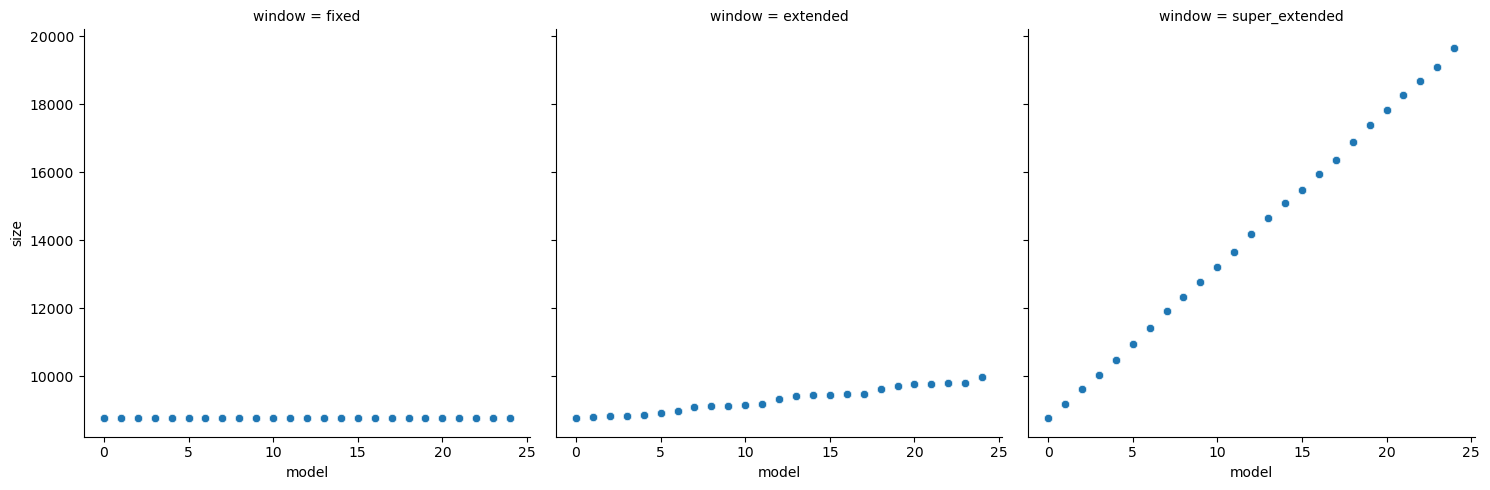

In [4]:
import seaborn as sns
sns.relplot(predictions[['window', 'model', 'size']], x='model', y='size', col='window')